In [ ]:
pip install pandas
pip install plotly
pip install scikit-survival
pip install --upgrade nbformat
pip install matplotlib
pip install pandasgui
pip install seaborn

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px

Sur le jeu de données *support*, nous allons suivre la même démarche que celle utilisée précedemment pour le dataframe *metabric*.    
Nous détaillerons moins les étapes et nous contenterons ici de commenter les résultats.

# Imporation et exploration des données

In [81]:
support = pd.read_csv('support.csv')
print(support.head())
len (support)

   Unnamed: 0        x0   x1   x2   x3   x4   x5   x6     x7     x8    x9  \
0           0  82.70996  1.0  2.0  1.0  0.0  0.0  0.0  160.0   55.0  16.0   
1           1  79.66095  1.0  0.0  1.0  0.0  0.0  1.0   54.0   67.0  16.0   
2           2  23.39999  1.0  2.0  3.0  0.0  0.0  1.0   87.0  144.0  45.0   
3           3  53.07599  1.0  4.0  3.0  0.0  0.0  0.0   55.0  100.0  18.0   
4           4  71.79498  0.0  1.0  1.0  0.0  0.0  0.0   65.0  135.0  40.0   

        x10    x11        x12       x13  duration  event  
0  38.19531  142.0  19.000000  1.099854      30.0      1  
1  38.00000  142.0  10.000000  0.899902    1527.0      0  
2  37.29688  130.0   5.199219  1.199951      96.0      1  
3  36.00000  135.0   8.699219  0.799927     892.0      0  
4  38.59375  146.0   0.099991  0.399963       7.0      1  


8873

En plus des variables cllassique en analyse de survie que sont *duration* et *event*, nous avons 14 variables explicatives.  
Parmi elles:  
- 8 sont des variables quantitatives: x0, x7, x8, x9, x10, x11, x12 et x13. Nous les **standardisons**.
- 3 variables catégorielles: x1, x4, x5
- 3 variables de type oridinal: x2 (de 0 à 9), x3 (de 0 à 7), et x6 (de 0 à 2)  

Note: n'ayant pas d'informations concernant le jeu de données, nous pouvons nous poser la question concernant la nature des variables x2, x3 et x6.   
Elles pourraient potentiellement être des variables catégorielles où chaque valeur que peut prendre la variable coderait alors une catégorie (auquel cas, nous pourrions les *one hot encoder*), nous les traiterons ici comme des variables ordinales.   

Le dataframe contient 8873 observations.


### Pré-traitement

In [133]:
# Supprimer la première colonne (index)
data = support.drop(support.columns[0], axis=1)

# Transformer la colonne event en booléen
data['event'] = data['event'].astype(bool)

# Standardiser les variables quantitatives
columns_to_standardize = ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])
print(data.head())

# Valeur maximale de la variable duration
max_duration = data['duration'].max()
print(f"Valeur maximale de duration : {max_duration}")

         x0   x1   x2   x3   x4   x5   x6        x7        x8        x9  \
0  1.285896  1.0  2.0  1.0  0.0  0.0  0.0  2.712545 -1.340135 -0.764142   
1  1.090666  1.0  0.0  1.0  0.0  0.0  1.0 -1.097247 -0.961532 -0.764142   
2 -2.511770  1.0  2.0  3.0  0.0  0.0  1.0  0.088821  1.467837  2.248417   
3 -0.611591  1.0  4.0  3.0  0.0  0.0  0.0 -1.061305  0.079626 -0.556379   
4  0.587001  0.0  1.0  1.0  0.0  0.0  0.0 -0.701891  1.183885  1.729010   

        x10       x11       x12       x13  duration  event  
0  0.862547  0.730526  0.716630 -0.399353      30.0   True  
1  0.707008  0.730526 -0.253960 -0.517394    1527.0  False  
2  0.147065 -1.246333 -0.771692 -0.340261      96.0   True  
3 -0.885730 -0.422642 -0.394240 -0.576414     892.0  False  
4  1.179852  1.389479 -1.321610 -0.812530       7.0   True  
Valeur maximale de duration : 2029.0


# Modélisation de la survie, méhode Kaplan-Meier

In [134]:
import nbformat
from sksurv.nonparametric import kaplan_meier_estimator

# Conserver les 2 dernières colonnes
d = data[['duration', 'event']]

# Calculer les temps et les probabilités de survie
times, km_survival_probabilities = kaplan_meier_estimator(d['event'], d['duration'])

# Créer un DataFrame vide pour les données de la courbe
km_proba = pd.DataFrame({
    "time": times,
    "survival_curve": km_survival_probabilities
})

# Tracer la courbe de survie de Kaplan-Meier
fig = px.line(
    km_proba,
    x="time",
    y="survival_curve",
    title="Courbe de survie de Kaplan-Meier",
)

# Ajouter une ligne pour la médiane de survie
fig.add_hline(
    y=0.50,
    annotation_text="Median",
    line_dash="dash",
    line_color="red",
    annotation_font_color="red",
)

# Mise à jour de la mise en page
fig.update_layout(
    height=500,
    width=800,
    xaxis_title="Temps",
    yaxis_title=r"Probabilité de survie",  
    yaxis_range=[0, 1],
)

La courbe de survie est ici très différente que celle obtenue avec le dataframe *metabric*.
Celle obervée ici ressemble plus à une hyperbole.   
Chose importante, tous les individus (encore suivis en fin de période) n'ont pas connu l'événement d'intêret avant la fin de la période d'observations. 


### Individus censurés

In [135]:
# Nombre d'individus sortis en cours de période d'observation
count = data[(data['duration'] < 2029) & (data['event'] == 0)].shape[0]
print(f"Nombre d'individus sorti de l'étude avant la fin de la période d'observation : {count}")

# Nombre d'individus toujours observés à la fin de la période d'observation n'ayant pas connu l'événement 
count = data[(data['duration'] == 2029) & (data['event'] == 0)].shape[0]
print(f"Nombre d'individus toujours observés à la fin de la période d'observation n'ayant pas connu l'événement : {count}")

Nombre d'individus sorti de l'étude avant la fin de la période d'observation : 2832
Nombre d'individus toujours observés à la fin de la période d'observation n'ayant pas connu l'événement : 5


Ces deux valeurs sont à rapprocher du pourcentage de survie en fin de période d'observation sur le graphique de la courbe de survie.  
En effet, la courbe de survie utilise uniquement les événements pour calculer les probabilités, et les individus censurés sont pris en compte en ajustant les effectifs restants pour les calculs de risque.


## Brier score modèle Kaplan-Meier

### Création jeux d'entraînement et test

In [121]:
from sklearn.model_selection import train_test_split

# création de jeux de données entraînement et test avec jeu de features

def train_test_split_within(X, y, idx, **kwargs):
    """Ensure that test data durations are within train data durations."""
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx, **kwargs)
    mask_duration_inliers = y_test['duration'] < y_train['duration'].max()
    X_test = X_test[mask_duration_inliers]
    y_test = y_test[mask_duration_inliers]
    idx_test = idx_test[mask_duration_inliers]
    return X_train, X_test, y_train, y_test, idx_train, idx_test

# Remplacez 'features' et 'd' par vos DataFrames
X = data.iloc[:, :14]
y = d

# Application de la division train-test avec test_size=0.75
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split_within(
    X, d, np.arange(X.shape[0]), test_size=0.80, random_state=1
)
print (X_train) # à supprimer !!!!!!!!!!!!!!!!!
print (X_test)

print (y_train)
print (y_test)

print (idx_train)
print (idx_test)


            x0   x1   x2   x3   x4   x5   x6        x7        x8        x9  \
6626  1.543301  1.0  1.0  1.0  0.0  0.0  2.0 -0.486242  1.373187  0.482434   
4609  0.093322  1.0  2.0  2.0  0.0  0.0  0.0  1.131122  0.899933 -0.348617   
4163  1.846936  1.0  2.0  1.0  0.0  0.0  2.0 -1.133188  0.710631  0.274671   
2585 -0.219787  0.0  4.0  1.0  1.0  0.0  1.0  1.993717  0.395129  2.767823   
8073  1.375154  0.0  0.0  1.0  0.0  0.0  1.0  0.412294 -1.024633 -0.348617   
...        ...  ...  ...  ...  ...  ...  ...       ...       ...       ...   
2895  0.493195  1.0  2.0  1.0  0.0  0.0  0.0 -0.809715 -1.024633 -0.348617   
7813  0.041395  0.0  4.0  1.0  1.0  0.0  0.0 -0.773774  0.079626  0.170790   
905  -0.700851  0.0  1.0  1.0  0.0  0.0  2.0  0.304469  1.215435  0.066909   
5192 -0.614729  0.0  5.0  2.0  1.0  0.0  1.0 -0.054945 -1.340135 -1.179667   
235  -0.369684  1.0  2.0  1.0  1.0  0.0  1.0  1.670244 -0.456728  0.794078   

           x10       x11       x12       x13  
6626  1.260731 -

### Préparation des données 

In [98]:

## courbe de survie sur le training set y_train
km_times_train, km_survival_curve_train = kaplan_meier_estimator(
    y_train['event'], y_train['duration'])
# km_times_train contient les instants où les événements sont observés.
# km_survival_curve_train contient les probabilités de survie estimées à ces instants.

## Interpolation sur l'ensemble de la grille de temps 
from scipy.interpolate import interp1d
km_predict = interp1d(
    km_times_train,
    km_survival_curve_train,
    kind="previous",  
    bounds_error=False,
    fill_value="extrapolate",)

## Création d'une grille de temps pour les prédictions 
def make_test_time_grid(y_train, n_steps=300):          # 300 points 
    """Bound times to the range of duration."""
    observed_duration = y_test.query("event > 0")['duration']
    
    # trim 1% of the span, 0.5% on each end:
    span = observed_duration.max() - observed_duration.min()
    start = observed_duration.min() + 0.005 * span # Les valeurs de début et de fin de la grille sont ajustées en retirant 0,5 % aux extrémités de la durée totale (span)... 
    stop = observed_duration.max() - 0.005 * span   # ...pour éviter les erreurs potentielles aux bords de la distribution.
    return np.linspace(start, stop, num=n_steps)

time_grid = make_test_time_grid(y_train)

### Courbe Brier score du modèle Kaplan Meier

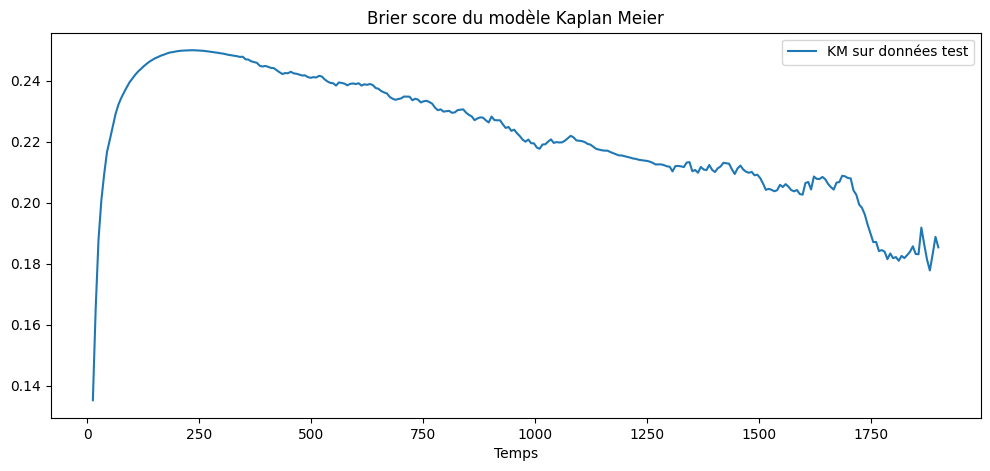

In [99]:
km_curve = km_predict(time_grid)
y_pred_km_test = np.vstack([km_curve] * X_test.shape[0])

from sksurv.metrics import brier_score
def as_sksurv_recarray(y_frame):
    """Return scikit-survival's specific target format."""
    y_recarray = np.empty(
        shape=y_frame.shape[0],
        dtype=[('event', np.bool_), ('duration', np.float64)],
    )
    y_recarray['event'] = y_frame['event']
    y_recarray['duration'] = y_frame['duration']
    return y_recarray

_, km_brier_scores = brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(time_grid, km_brier_scores, label="KM sur données test");
ax.set(
    title="Brier score du modèle Kaplan Meier",
    xlabel = "Temps",
)
ax.legend();


Début de l’observation (faible Brier score) : La faible valeur au début indique des prévisions précises au départ. 

Augmentation rapide : les événements commencent à apparaître plus fréquemment et les erreurs de prédiction augmentent. 

Diminution progressive (phase centrale) : La réduction indique que les prédictions sont à nouveau mieux alignées avec les événements observés.

Augmentation en fin de période d'observation : Cette augmentation est plus inhabituelle. Elle est sans doute due à l’augmentation des censures. Le nombre réduit d'individus à ce moment-là peut déstabiliser les prévisions du modèle. 

In [67]:
from sksurv.metrics import integrated_brier_score

km_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=y_pred_km_test,
    times=time_grid,
)
print(f"IBS de l'estimateur Kaplan-Meier: {km_ibs_test:.3f}")

IBS de l'estimateur Kaplan-Meier: 0.222


In [68]:
# IBS courbe de survie linéaire (droite ddécroissante de 1 à 0)

linear_survival_curve = np.linspace(1.0, 0.0, time_grid.shape[0])
constant_linear_survival_curves = [linear_survival_curve] * y_test.shape[0]

linear_survival_ibs_test = integrated_brier_score(
    survival_train=as_sksurv_recarray(y_train),
    survival_test=as_sksurv_recarray(y_test),
    estimate=constant_linear_survival_curves,
    times=time_grid,)
print(f"IBS de l'estimateur linéaire: {linear_survival_ibs_test:.3f}")

IBS de l'estimateur linéaire: 0.280


Commentaire: malgré la forme inhabituelle de la courbe du Brier score du modèle K-M, il fait mieux que le modèle linéaire.   
Notons que la forme très particulière de la courbe de survie peut expliquer le mauvais score (relatif) du modèle linéaire.

# Indice de concordance (C-index) sur modèle K-M

In [69]:
from sksurv.metrics import concordance_index_censored

def compute_c_index(event, duration, survival_curves):
    survival_curves = np.asarray(survival_curves)
    if survival_curves.ndim != 2:
        raise ValueError(
            "`survival_probs` must be a 2d array of "
            f"shape (n_samples, times), got {survival_curves.shape}"
        )
    assert event.shape[0] == duration.shape[0], survival_curves.shape[0]

    cumulative_hazard = survival_to_risk_estimate(survival_curves)
    metrics = concordance_index_censored(event, duration, cumulative_hazard)
    return metrics[0]

def survival_to_risk_estimate(survival_probs_matrix):
    return -np.log(survival_probs_matrix + 1e-8).sum(axis=1)

km_c_index_test = compute_c_index(y_test['event'], y_test['duration'], y_pred_km_test)
print(f"C-index de l'estimateur K-M: {km_c_index_test}")

C-index de l'estimateur K-M: 0.5


Même C-index que pour le modèle K-M du dataframe *metabric*. C'est à dire qu'ici non plus, notre modèle K-M ne fait pas mieux que le hasard.  

Résumons les deux métriques pour nos deux modèles: Kaplan Meier et modèle linéaire:

,Model,IBS,C-index
0,Constant linear,0.2796,0.5
1,Kaplan-Meier,0.2224,0.5


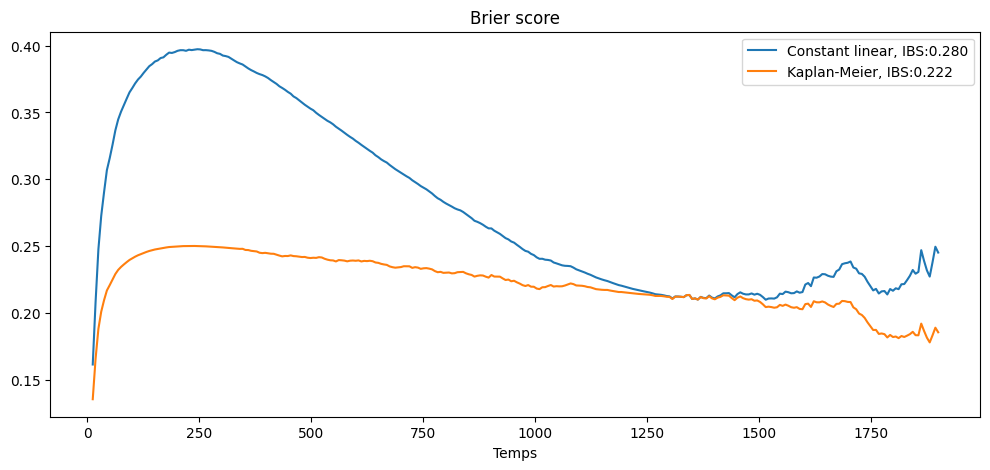

In [103]:
class SurvivalAnalysisEvaluator:
    
    def __init__(self, y_train, y_test, time_grid):
        self.model_data = {}
        self.y_train = as_sksurv_recarray(y_train)
        self.y_test = as_sksurv_recarray(y_test)
        self.time_grid = time_grid
        
    def add_model(self, model_name, survival_curves):
        survival_curves = np.asarray(survival_curves)
        _, brier_scores = brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        ibs = integrated_brier_score(
            survival_train=self.y_train,
            survival_test=self.y_test,
            estimate=survival_curves,
            times=self.time_grid,
        )
        c_index = compute_c_index(
            self.y_test['event'],
            self.y_test['duration'],
            survival_curves,
        )
        self.model_data[model_name] = {
            "brier_scores": brier_scores,
            "ibs": ibs,
            "c_index": c_index,
            "survival_curves": survival_curves,
        }

    def metrics_table(self):
        return pd.DataFrame([
            {
                "Model": model_name,
                "IBS": info["ibs"],
                "C-index": info["c_index"],
            }
            for model_name, info in self.model_data.items()
        ]).round(decimals=4)
        
    def plot(self, model_names=None):
        if model_names is None:
            model_names = list(self.model_data.keys())
        fig, ax = plt.subplots(figsize=(12, 5))
        self._plot_brier_scores(model_names, ax=ax)

    def _plot_brier_scores(self, model_names, ax):
        for model_name in model_names:
            info = self.model_data[model_name]
            ax.plot(
                self.time_grid,
                info["brier_scores"],
                label=f"{model_name}, IBS:{info['ibs']:.3f}");
        ax.set(
            title="Brier score",
            xlabel="Temps",
        )
        ax.legend()
        
    def __call__(self, model_name, survival_curves, model_names=None):
        self.add_model(model_name, survival_curves)
        self.plot(model_names=model_names)
        return self.metrics_table()

evaluator = SurvivalAnalysisEvaluator(y_train, y_test, time_grid)
evaluator.add_model("Constant linear", constant_linear_survival_curves)
evaluator.add_model("Kaplan-Meier", y_pred_km_test)
evaluator.plot()
evaluator.metrics_table()

# Modèle Cox 

Nous essayons deux modèles, le premier en utilisant en utilisant les variables x2, x3 et x6 telles quelles, le deuxième en les considérant comme variables ordinales.

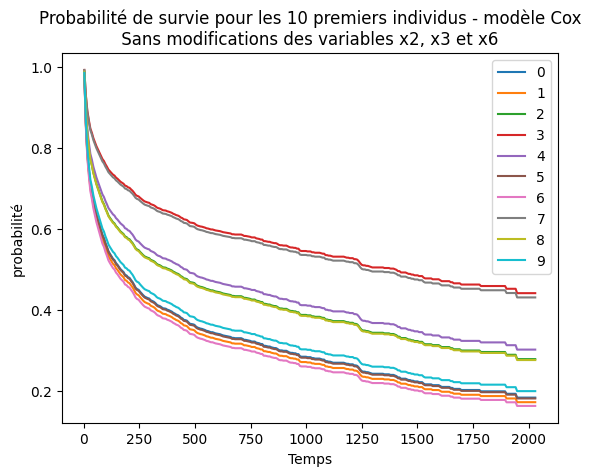

In [138]:
# modèel cox sans modification pour variables ordinales

from sksurv.linear_model import CoxPHSurvivalAnalysis
cox_ph = CoxPHSurvivalAnalysis(alpha=1e-4)  

# Entraînement du modèle Cpx
cox_ph.fit(X_train, as_sksurv_recarray(y_train))
# Prédiction des fonctions de survie sur les données de test
cox_ph_survival_funcs = cox_ph.predict_survival_function(X_test)

# Graphique des probabilités de survie pour les 10 premières observations de X_test
fig, ax = plt.subplots()
time_grid = np.linspace(y_train['duration'].min(), y_train['duration'].max(), num=300)

for idx, cox_ph_survival_func in enumerate(cox_ph_survival_funcs[:10]):
    survival_curve = cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)

ax.set(
    title="Probabilité de survie pour les 10 premiers individus - modèle Cox\n Sans modifications des variables x2, x3 et x6 ",
    xlabel="Temps",
    ylabel="probabilité",
)
plt.legend()
plt.show()

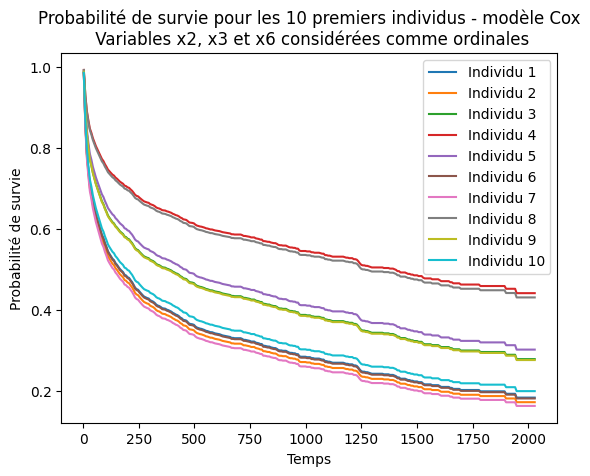

In [139]:
# Cox en considérant x2, x3 et x6 comme variables ordinales

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Définir les colonnes ordinales
ordinal_features = ['x2', 'x3', 'x6']  

# Créer un préprocesseur pour appliquer l'OrdinalEncoder aux variables ordinales uniquement
column_transformer = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2]]), ordinal_features),
        ('passthrough', 'passthrough', [col for col in X_train.columns if col not in ordinal_features])  # Passer les autres colonnes sans traitement
    ],
    remainder='passthrough'  # Les autres colonnes restent inchangées
)

# Créer un pipeline avec le préprocesseur et le modèle CoxPH
pipeline = make_pipeline(
    column_transformer,
    CoxPHSurvivalAnalysis(alpha=1e-4)
)

# Entraînement du modèle sur les données d'entraînement (les données sont prétraitées automatiquement par le pipeline)
pipeline.fit(X_train, as_sksurv_recarray(y_train))

# Prédiction des fonctions de survie sur les données de test
cox_ph_survival_funcs = pipeline.predict_survival_function(X_test)

# Graphique des probabilités de survie pour les 10 premiers individus de X_test
fig, ax = plt.subplots()
time_grid = np.linspace(y_train['duration'].min(), y_train['duration'].max(), num=300)

for idx, cox_ph_survival_func in enumerate(cox_ph_survival_funcs[:10]):
    survival_curve = cox_ph_survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=f'Individu {idx+1}')

ax.set(
    title="Probabilité de survie pour les 10 premiers individus - modèle Cox\n Variables x2, x3 et x6 considérées comme ordinales",
    xlabel="Temps",
    ylabel="Probabilité de survie",
)
plt.legend()
plt.show()


Non voyons ici que la manipulation des données pour que le modèle les traite comme des variables ordinales ne change rien aux prédictions.

### Poids des features

<>:27: SyntaxWarning:

invalid escape sequence '\l'

<>:27: SyntaxWarning:

invalid escape sequence '\l'

C:\Users\olivi\AppData\Local\Temp\ipykernel_15224\917821109.py:27: SyntaxWarning:

invalid escape sequence '\l'

C:\Users\olivi\AppData\Local\Temp\ipykernel_15224\917821109.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




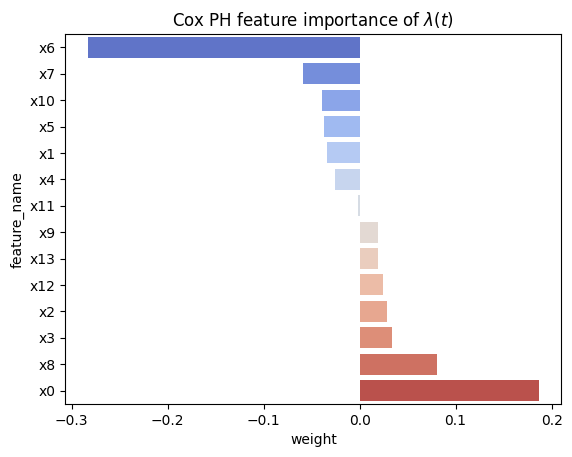

In [117]:
# Extraction du modèle CoxPH depuis le pipeline
cox_ph_model = pipeline.named_steps['coxphsurvivalanalysis']

# Extraction des noms des features et des poids
transformed_feature_names = ordinal_features + [col for col in X_train.columns if col not in ordinal_features]
weights = cox_ph_model.coef_

# Créer un DataFrame avec les noms des features et leurs poids
features = (
    pd.DataFrame(
        dict(
            feature_name=transformed_feature_names,
            weight=weights,
        )
    )
    .sort_values("weight")
)

# Visualiser l'importance des features 
ax = sns.barplot(
    data=features, 
    y="feature_name", 
    x="weight", 
    orient="h", 
    palette="coolwarm"
)
ax.set_title("Cox PH feature importance of $\lambda(t)$")
plt.show()

2 variables se détachent nettement quant à leur poids: x6 (en négatif) et x0 (en positif).

Calculons le Brier score et le C-index pour le modèle Cox et comparons le aux modèles précédents.

,Model,IBS,C-index
0,Constant linear,0.2796,0.5000
1,Kaplan-Meier,0.2224,0.5000
2,Cox PH,0.2120,0.5677


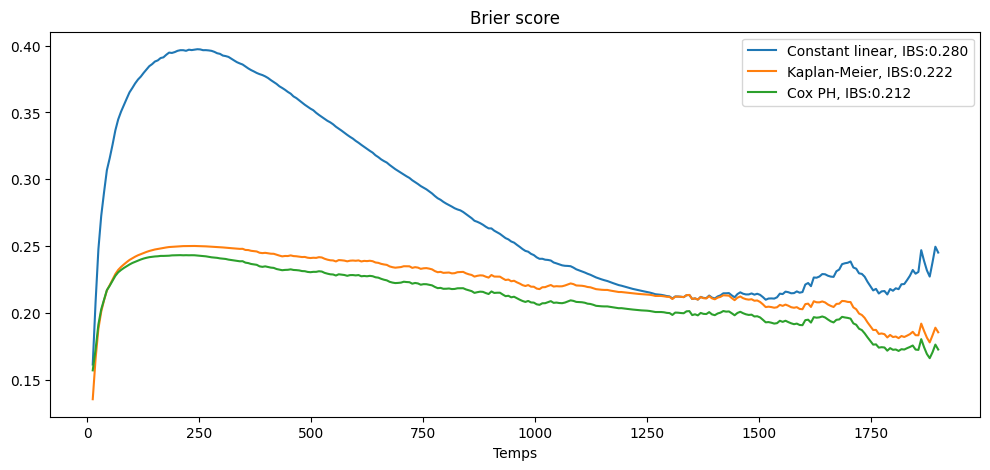

In [118]:
cox_survival_curves = np.vstack(
    [
        cox_ph_survival_func(time_grid)
        for cox_ph_survival_func in cox_ph_survival_funcs
    ]
)
evaluator("Cox PH", cox_survival_curves)

Le modèle Cox fait mieux sur les deux métriques.   
La courbe du Brier score montre que le résultat est meilleur sur toute la durée de l'étude et que la différence est encore plus marquée dans la zone centrale, là où l'erreur est la plus importante.   
les résultats du modèle Cox avec ou sans pipeline pour considérer les variables x2, x3 et x6 comme des variables ordinales sont identiques.  
Non représenté ici: nous avons essayé les mêmes modèles avec les variables quantitatives non-standardisées, les résultats sont également identiques.

# COX polynomial (avec interactions)

,Model,IBS,C-index
0,Constant linear,0.2796,0.5000
1,Kaplan-Meier,0.2224,0.5000
2,Cox PH,0.2120,0.5677
3,Polynomial Cox PH,0.2200,0.5844


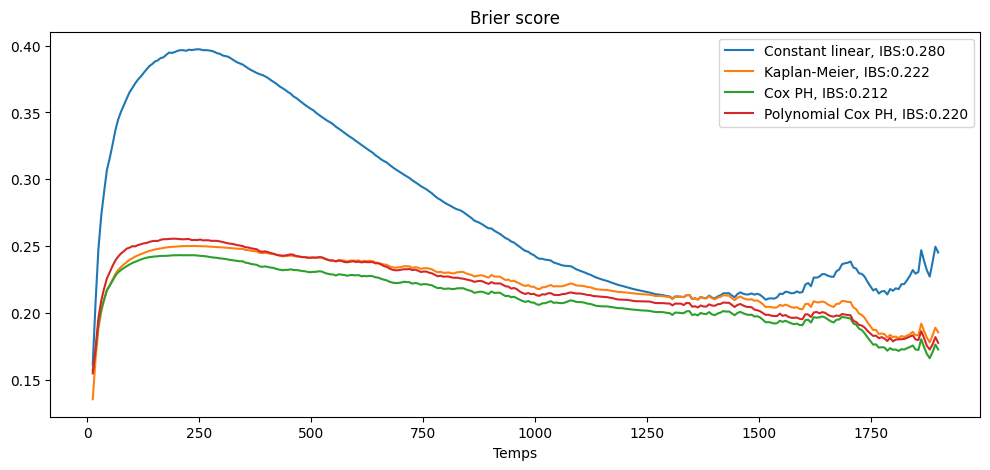

In [125]:
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer

# Créer un préprocesseur pour appliquer SplineTransformer uniquement aux colonnes quantitatives
column_transformer = ColumnTransformer(
    transformers=[
        ('spline', SplineTransformer(), ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']),  # Appliquer SplineTransformer
        ('passthrough', 'passthrough', [col for col in X_train.columns if col not in ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']])  # Passer les autres colonnes
    ])

# Créer un pipeline avec le ColumnTransformer, Nystroem et le modèle CoxPH
poly_cox_ph = make_pipeline(
    column_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300),
    CoxPHSurvivalAnalysis(alpha=1e-4)
)

# Entraînement du modèle sur les données d'entraînement
poly_cox_ph.fit(X_train, as_sksurv_recarray(y_train))

# Prédiction des fonctions de survie sur les données de test
poly_cox_ph_survival_funcs = poly_cox_ph.predict_survival_function(X_test)
poly_cox_ph_survival_curves = np.vstack(
    [
        poly_cox_ph_survival_func(time_grid)
        for poly_cox_ph_survival_func in poly_cox_ph_survival_funcs
    ]
)
evaluator("Polynomial Cox PH", poly_cox_ph_survival_curves)


La modèle Cox polynomial fait mieux que tous les autres modèles concernant le C-index mais il ne parvient pas à dépasser le modèle Cox simple concernant le Brier score.

Non représenté ici: nous avons testé d'autres valeurs de degré de polynomes, le degré 2 est celui qui offrait le meilleur compromis sur les métriques et le temps de calcul. C'est celui que nous avons retenu.

# Random survival forest

In [126]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(n_estimators=100, max_depth=8, n_jobs=-1)  # "n_estimators=10" : Nombre d'arbres dans la forêt  "n_jobs=-1" : 

# Entraînement du modèle
rsf.fit(X_train, as_sksurv_recarray(y_train))


RandomSurvivalForest(max_depth=8, n_jobs=-1)

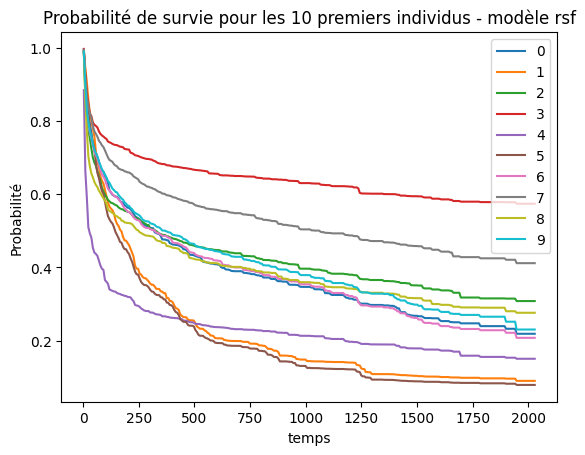

In [140]:
# utilise le modèle RandomSurvivalForest entraîné (rsf) pour prédire la fonction de survie sur X_test
rsf_survival_funcs = rsf.predict_survival_function(X_test) #

fig, ax = plt.subplots()
for idx, survival_func in enumerate(rsf_survival_funcs[:10]):
    survival_curve = survival_func(time_grid)
    ax.plot(time_grid, survival_curve, label=idx)
ax.set(
    title="Probabilité de survie pour les 10 premiers individus - modèle rsf",
    xlabel="temps",
    ylabel="Probabilité",
)
plt.legend();

,Model,IBS,C-index
0,Constant linear,0.2796,0.5000
1,Kaplan-Meier,0.2224,0.5000
2,Cox PH,0.2120,0.5677
3,Polynomial Cox PH,0.2200,0.5844
4,Random Survival Forest,0.1999,0.6022


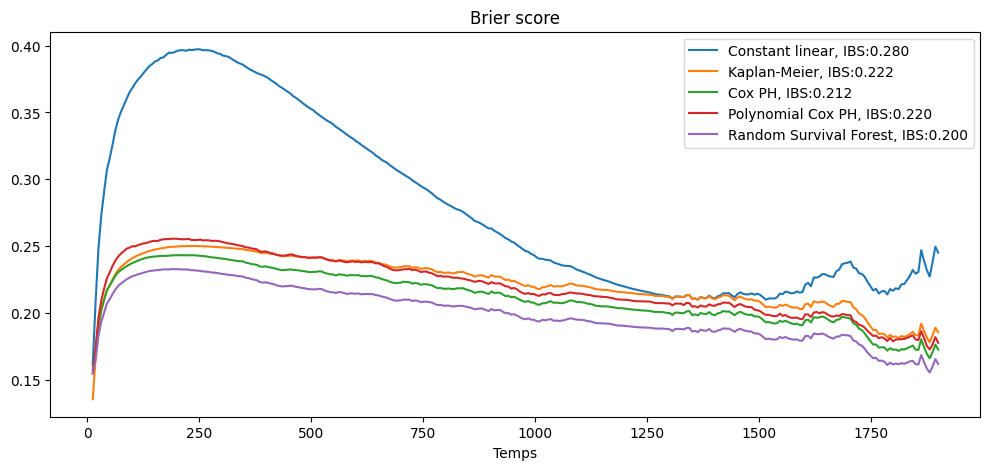

In [128]:
rsf_survival_curves = np.vstack(
    [func(time_grid) for func in rsf_survival_funcs]
)
evaluator("Random Survival Forest", rsf_survival_curves)

De manière assez nette, le modèle *rsf* obtient les meilleurs résultats sur les deux métriques.

Conclusion : Pour ce jeu de données, c'est le modèle *rsf* que nous retenons comme étant le plus performant. Notons que nous n'avons pas cherché à optimiser les modèles Cox et *rsf* dans cette étude.  
Le nombre d'arbres dans la foret, leur profondeur, le nombre minimal d'échantillons pour diviser un noeud, le nombre de features à considérer pour chaque division, etc. sont autant de paramêtres que l'on pourrait chercher à optimiser.
